In [ ]:
import datetime
import os

import pandas as pd

from src.config import DATA_DIR, MODEL_DIR, PARAM_DIR
from src.recommendation.LDA import train_lda_model, model_type
from src.recommendation.all_evaluation import _results
from src.recommendation.evaluation import evaluate
from src.recommendation.mixture_functions import get_train
from src.util.data_io import get_dataset
from src.util.eval_measures import eval_lst
from src.util.io import save_pickle

FMT = '%Y-%m-%d %H:%M:%S'
train_model, model_type = train_lda_model, model_type


In [4]:
model_type


'lda_model'

In [5]:
data_dir = os.path.join(DATA_DIR, 'day')
results_dir = os.path.join(MODEL_DIR, 'tuning')


In [6]:
print(eval_lst)


[['recall', [5]], ['precision', [5]], ['nDCG', [5]]]


In [7]:
# subset Jan 20 - 22, 2015
datasets = ['120', '121', '122']


In [16]:
k_vals = [5, 10, 50, 100, 500]


In [17]:
overwrite = False
save_multinomials = True


def hours_minutes_seconds(td):
    return '{:02}:{:02}:{:02}'.format(td.seconds // 3600, (td.seconds // 60) % 60, td.seconds % 60)


def eval_dataset(dataset, k_vals):
    result_dic = {}

    for n_components in k_vals:
        print(n_components)
        train, val, test = get_dataset(dataset, data_dir)
        start_time = datetime.datetime.now()
        all_multinomials = train_model(train, val, test, results_dir,
                                       dataset, overwrite=False, save_multinomials=True,
                                       n_components=n_components, is_tune=True)
        end_time = datetime.datetime.now()
        time_used = hours_minutes_seconds(end_time - start_time)
        print('time_used', time_used)
        dataset, eval_result = _results(dataset, eval_lst, val, all_multinomials)
        eval_result.append(['time_used', time_used])
        result_dic.update({n_components: eval_result})

    df = pd.DataFrame(result_dic).T
    df.columns = [item for sublist in list(result_dic.values())[0] for item in sublist[:1]]
    for col in df.columns:
        df[col] = df[col].apply(lambda s: s[1])

    return df


In [18]:
dfs = dict()
for dataset in datasets:
    dataset = str(dataset)
    df = eval_dataset(dataset, k_vals)
    dfs.update({dataset: df})


5
2019-10-22 13:23:59,182 INFO --> Loading data for 120
time_used 00:00:16
recall@5: 0.05069
precision@5: 0.05519
nDCG@5: 0.07130
10
2019-10-22 13:25:06,894 INFO --> Loading data for 120
time_used 00:00:05
recall@5: 0.04832
precision@5: 0.05315
nDCG@5: 0.06941
50
2019-10-22 13:26:02,659 INFO --> Loading data for 120
time_used 00:00:05
recall@5: 0.05439
precision@5: 0.05513
nDCG@5: 0.07323
100
2019-10-22 13:26:58,851 INFO --> Loading data for 120
time_used 00:00:03
recall@5: 0.00017
precision@5: 0.00019
nDCG@5: 0.00020
500
2019-10-22 13:27:33,323 INFO --> Loading data for 120
time_used 00:00:03
recall@5: 0.00017
precision@5: 0.00019
nDCG@5: 0.00020
5
2019-10-22 13:28:08,130 INFO --> Loading data for 121
time_used 00:00:16
recall@5: 0.04836
precision@5: 0.05383
nDCG@5: 0.07025
10
2019-10-22 13:29:19,662 INFO --> Loading data for 121
time_used 00:00:05
recall@5: 0.04878
precision@5: 0.05537
nDCG@5: 0.07095
50
2019-10-22 13:30:20,521 INFO --> Loading data for 121
time_used 00:00:05
recall@

In [19]:
df


,recall@5,precision@5,nDCG@5,time_used
5,0.052891,0.058647,0.075780,00:00:16
10,0.053406,0.060930,0.077386,00:00:06
50,0.056951,0.059593,0.078152,00:00:05
100,0.000166,0.000194,0.000201,00:00:03
500,0.000166,0.000194,0.000201,00:00:03


In [20]:
eval_measure = df.columns.tolist()
eval_measure


['recall@5', 'precision@5', 'nDCG@5', 'time_used']

In [21]:
def plot_metric(col):
    try:
        df_plot = pd.DataFrame({c: df[col] for c, df in dfs.items()})
        df_plot.plot(logx=True, xticks=k_vals, title=col.upper() + ' for different k')
    except:
        # time is not numeric value
        return df_plot


In [22]:
for k, df in dfs.items():
    print(k)
    print(df['nDCG@5'].idxmax())


120
50
121
50
122
50


          120       121       122
5    00:00:16  00:00:16  00:00:16
10   00:00:05  00:00:05  00:00:06
50   00:00:05  00:00:05  00:00:05
100  00:00:03  00:00:03  00:00:03
500  00:00:03  00:00:03  00:00:03


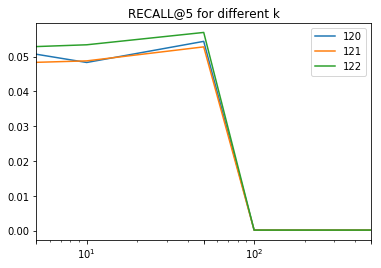

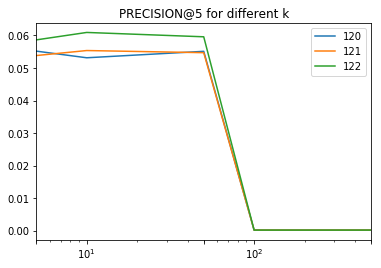

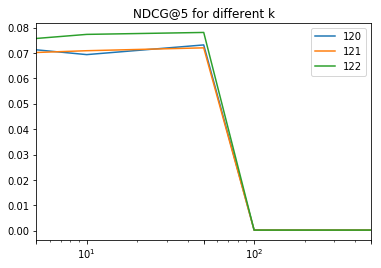

In [23]:
for col in eval_measure:
    df_time = plot_metric(col)
print(df_time)


In [25]:
save_pickle(os.path.join(PARAM_DIR, model_type), 50, False)
